<a href="https://colab.research.google.com/github/gyulab/GTEEGyujun-MLproject/blob/gatecap-tcad-modeling/iwo_7nm_training_cgd_train_030724.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from re import L
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch import optim
from torch.utils import data
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


import statistics
import datetime
import os
import csv
import math
import time
import numpy as np
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.getcwd()

start = time.time()


idvg_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/022224_7nm_tech_3T_Id_Vg_wo25.csv', encoding='utf8')
cv_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/022224_7nm_tech_3T_Cgg_wo25.csv', encoding='utf8')
#cv_temp=pd.read_csv(r'./cv_iwo_0206.csv', encoding='utf8')
# idvg=idvg_temp.values

lch = [0.007]
vd_temp=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]#, 2.1, 2.2, 2.3, 2.4]

vd = np.array(vd_temp)
vg_temp=idvg_temp.iloc[:,0]
vg = np.array(vg_temp.values)
lch = np.array(lch)

def Logset(target):
    temp = np.array(target)
    # temp[temp<0]=abs(temp)
    # temp = temp.tolist() not use
    temp = np.log10(temp)
    return temp

It = []
for l in list(range(len(lch))):
    for i in list(range(len(vd))):
        temp = idvg_temp.iloc[:, 2*i+1+2*len(vd)*l]
        temp = np.array(temp.values)
        It.extend(temp)

It = Logset(It)
# vd = Logset(vd)

def normaliz(target):
    Min = min(target)
    Val = target - Min
    Max = max(Val)
    if Max == 0:
        Norm = 1
    else:
        Norm = 1 / Max
    return (Norm, Val, Min)

(normVg, Vg_1, MinVg)=normaliz(vg)
(normVd, Vd_1, MinVd)=normaliz(vd)
(normIt, It_1, MinIt)=normaliz(It)
(normLch, Lch_1, MinLch) = normaliz(lch)

Vg = normVg*Vg_1
Vd = normVd*Vd_1
I = normIt*It_1
Lch = normLch*Lch_1

datasets = []
for l in list(range(len(Lch))):
    for i in list(range(len(vd))):
        for j in list(range(len(vg))):
            temp=[Vg[j],Vd[i],Lch[l], I[j+len(vg)*(i+len(vd)*l)]]
            datasets.append(temp)

V = []
for i in list(range(len(datasets))):
    temp = [datasets[i][0], datasets[i][1], datasets[i][2]]
    V.append(temp)

I = []
for i in list(range(len(datasets))):
    temp = [datasets[i][3]]
    I.append(temp)

V = torch.tensor(V)
I = torch.tensor(I)

# dataset = list(zip(V, I))
x_train, x_test, y_train, y_test = train_test_split(V, I, test_size=0.1, random_state=41)
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32)
testdataloader = DataLoader(TensorDataset(x_test, y_test))

# print(idvg_temp.values)
It_g = [10**x for x in It]
CM_git = np.corrcoef(vg,It_g[len(vg)*10:len(vg)*11])
Itd=[]
print(len(It_g))
print(len(vg))
print(len(vd))
print(len(lch))

for i in list(range(len(vd))):
    Itd.append(It_g[len(vg)-23+len(vg)*i])
print(Itd)
CM_dit = np.corrcoef(vd, Itd)

print(lch)
print()
Itl = []
print(It_g[len(vg)*len(vd)-4])
#print(It_g[len(vg)*len(vd)*8-4])
print(list(range(len(lch))))
for i in list(range(len(lch))):
    Itl.append(It[len(vg)*len(vd)*(i+1)-20] )
print(Itl)
CM_lit = np.corrcoef(Lch, Itl)

print("1:{}".format(CM_git))
print("2:{}".format(CM_dit))
print("3:{}".format(CM_lit))

# Define the neural network class
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(3, 25)
        self.fc2 = torch.nn.Linear(25, 12)
        self.fc3 = torch.nn.Linear(12, 1)
        self.dropout = torch.nn.Dropout(0.2)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.elu = torch.nn.ELU(1.0)
        self.Softsign = torch.nn.Softsign()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        self.bn1 = torch.nn.BatchNorm1d(25)
        self.bn2 = torch.nn.BatchNorm1d(12)
        self.bn3 = torch.nn.BatchNorm1d(1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        return x

# Create an instance of the MLP class
model = MLP()

torch.nn.init.xavier_uniform(model.fc1.weight)
torch.nn.init.xavier_uniform(model.fc2.weight)
torch.nn.init.xavier_uniform(model.fc3.weight)
# torch.nn.init.xavier_uniform(model.fc4.weight)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# losses = []
# criterion = nn.MSELoss() # <== 파이토치에서 제공하는 평균 제곱 오차 함수\
best_loss = float('inf')  # Initialize best loss to infinity
epochs_since_improvement = 0  # Initialize the count of epochs since the last improvement in loss

nb_epochs = 3000
MLoss = []
for epoch in range(0, nb_epochs):

    current_loss = 0.0
    losses = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(dataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        L_weight = 3
        #compute loss
        batch_loss = []
        for j in range(inputs.size(0)):
            input_j = inputs[j].reshape((1, inputs.shape[1]))
            if input_j[0,0]>0.3:
                batch_loss.append(L_weight*loss_function(outputs[j], targets[j]))
            else:
                batch_loss.append(loss_function(outputs[j], targets[j]))

        loss = torch.stack(batch_loss).mean()

        losses.append(loss.item())

        #perform backward pass
        loss.backward()
        #perform optimization
        optimizer.step()
        # Print statistics

    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

#print('Loss (epoch: %4d): %.8f' %(epoch+1, mean_loss))
# Print the loss only every 10 epochs
    if (epoch + 1) % 10 == 0:
        print('Loss (epoch: %4d): %.8f' % (epoch + 1, mean_loss))
    current_loss = 0.0
    # Check for improvement
    if mean_loss < best_loss:
        best_loss = mean_loss  # Update the best observed loss
        epochs_since_improvement = 0  # Reset count
    else:
        epochs_since_improvement += 1  # Increment count

    # Terminate training if no improvement in the last 10 epochs
    if epochs_since_improvement >= 10:
        print("No improvement in loss for 10 consecutive epochs, stopping training.")
        break
    MLoss.append(mean_loss)
    optimizer.step()
        # Print statistics
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)


# Process is complete.
print('Training process has finished.')

torch.save(model, 'IWO_idvg.pt')
torch.save(model.state_dict(), 'IWO_idvg_state_dict.pt')

####### loss vs. epoch #######
xloss = list(range(0, nb_epochs))
plt.plot(xloss, np.log10(MLoss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(xloss[500:], MLoss[500:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

with torch.no_grad():

    output = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(testdataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        output.append(outputs)
# Process is complete.
print('Training process has finished.')

output1 = np.power(10, output/normIt+MinIt)
ytest1 = np.power(10, y_test/normIt+MinIt)
plt.scatter(np.log10(output1), np.log10(ytest1))
a = [min(ytest1), max(ytest1)]
b = [min(ytest1), max(ytest1)]
plt.plot(np.log10(a), np.log10(b), 'k')
plt.plot(np.log10(a), np.log10(b), 'k')

plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()

plt.plot(a,b,'k')
plt.scatter(ytest1,output1)
plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()


answer_test = [i for sublist in ytest1.tolist() for i in sublist]
print(answer_test)
print(output1)

######################### IDVD Vg=0.48 ##############################
x_test = np.linspace(0.01, 2.4, num=30)
print(x_test)
# x_test = Logset(x_test.tolist())
X= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(0.48-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X.append(temp)

Pred_y=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y.append(pred_y)

I_pred =[np.power(10, i/normIt+MinIt) for i in Pred_y]

I_pred=np.array(I_pred)

I_final= []
for i in list(range(len(I_pred))):
    I_final.extend(I_pred[i])

######################### vg=0.75 IDVD ##############################

X1= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(0.75-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X1.append(temp)

Pred_y1=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X1[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y1.append(pred_y15)

I_pred1 =[np.power(10, i/normIt+MinIt) for i in Pred_y1]

I_pred1=np.array(I_pred1)

I_final1= []
for i in list(range(len(I_pred1))):
    I_final1.extend(I_pred1[i])

    ######################### vg=1.9 IDVD ##############################

X15= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(1.96154-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X15.append(temp)

Pred_y15=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X15[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y15.append(pred_y15)

I_pred15 =[np.power(10, i/normIt+MinIt) for i in Pred_y15]

I_pred15=np.array(I_pred15)

I_final15= []
for i in list(range(len(I_pred15))):
    I_final15.extend(I_pred15[i])

############# Vg = 2.5 IDVD ######################

X25= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(2.5-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X25.append(temp)

Pred_y25=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X25[i])
    pred_y25=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y25.append(pred_y25)

I_pred25 =[np.power(10, i/normIt+MinIt) for i in Pred_y25]

I_pred25=np.array(I_pred25)

I_final25= []
for i in list(range(len(I_pred25))):
    I_final25.extend(I_pred25[i])

#
Vd_test = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]
Id05_test = list(idvg_temp.iloc[11, 1::2][:-1])
Id1_test = list(idvg_temp.iloc[13, 1::2][:-1])
Id15_test = list(idvg_temp.iloc[22, 1::2][:-1])
Id_test =  list(idvg_temp.iloc[26, 1::2][:-1])
# x_test = np.power(10, x_test)

plt.scatter(Vd_test, Id05_test) ## TCAD
plt.scatter(Vd_test, Id1_test) ## TCAD
plt.scatter(Vd_test, Id15_test) ## TCAD
plt.scatter(Vd_test, Id_test) ## TCAD
plt.plot(x_test, I_final, label = "Vg = 0.48V")
plt.plot(x_test, I_final1, label = "Vg = 0.75V")
plt.plot(x_test, I_final15, label = "Vg = 1.96V")
plt.plot(x_test, I_final25, label = "Vg = 2.5V")
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Current [A/um]")
plt.legend()
plt.show()

plt.scatter(Vd_test, Id05_test) ## TCAD
plt.scatter(Vd_test, Id1_test) ## TCAD
plt.plot(x_test, I_final, label = "Vg = 0.48V")
plt.plot(x_test, I_final1, label = "Vg = 0.75V")
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Current [A/um]")
plt.legend()
plt.show()
print(np.round(x_test, 3).tolist)
print(I_final)
print(I_final1)
print(I_final15)
print("")

#################### IDVG #######################

xv_test = list(range(-10, 36, 1))
xv_test = np.array(xv_test)/10

(normVgtest, xv_test_1, MinVtest)=normaliz(xv_test)
Xv= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(xv_test_1))):
    temp=[(xv_test[i]-MinVg)*normVg, ((0.05)-MinVd)*normVd, 0]
    Xv.append(temp)

Predv_y=[]
for i in list(range(len(xv_test_1))):
    new_var =  torch.FloatTensor(Xv[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Predv_y.append(pred_y)

Iv_pred =[np.power(10, i/normIt+MinIt) for i in Predv_y]

Iv_pred=np.array(Iv_pred)

Iv_final= []
for i in list(range(len(Iv_pred))):
    Iv_final.extend(Iv_pred[i])

#### VD =1V ####

Xv11=[]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, ((1)-MinVd)*normVd, 0]
    Xv11.append(temp)

Predv_y11=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv11[i])
    pred_y11=model(new_var).data.numpy()
    Predv_y11.append(pred_y11)

Iv_pred11 =[np.power(10, i/normIt+MinIt) for i in Predv_y11]

Iv_pred11=np.array(Iv_pred11)

Iv_final11= []
for i in list(range(len(Iv_pred11))):
    Iv_final11.extend(Iv_pred11[i])

#### VD =3.4V #### 2.4

Xv25=[]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, ((2.4)-MinVd)*normVd, 0]
    Xv25.append(temp)

Predv_y25=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv25[i])
    pred_y25=model(new_var).data.numpy()
    Predv_y25.append(pred_y25)

Iv_pred25 =[np.power(10, i/normIt+MinIt) for i in Predv_y25]

Iv_pred25=np.array(Iv_pred25)

Iv_final25= []
for i in list(range(len(Iv_pred25))):
    Iv_final25.extend(Iv_pred25[i])

##### below is from TCAD #####
##### below is from TCAD #####
Vg_test = list(idvg_temp.iloc[:, 0])
Id0_test = list(idvg_temp.iloc[:, 3])
Id_test = list(idvg_temp.iloc[:, 23])
Id2_test = list(idvg_temp.iloc[:, 51])

plt.scatter(Vg_test, np.log10(Id0_test)) ## TCAD
plt.scatter(Vg_test, np.log10(Id_test)) ## TCAD
plt.scatter(Vg_test, np.log10(Id2_test)) ## TCAD
plt.plot(xv_test, np.log10(Iv_final), label = "VD = 0.05V")
plt.plot(xv_test, np.log10(Iv_final11), label = "VD = 1V")
plt.plot(xv_test, np.log10(Iv_final25), label = "VD = 2.4V")
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current [A/um]")
plt.legend()
plt.show()

plt.scatter(Vg_test, (Id0_test)) ## TCAD
plt.scatter(Vg_test, (Id_test)) ## TCAD
plt.scatter(Vg_test, (Id2_test)) ## TCAD
plt.plot(xv_test, (Iv_final), label = "VD = 0.05V")
plt.plot(xv_test, (Iv_final11), label = "VD = 1V")
plt.plot(xv_test, (Iv_final25), label = "VD = 2.4V")
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Current [A/um]")
plt.legend()
plt.show()

print(xv_test)
print(Iv_final)
print(Iv_final11)
print(Iv_final25)
print("")

# Instantiate the PyTorch model
model.load_state_dict(torch.load('IWO_idvg_state_dict.pt'))

# Extract the weights and biases from the model
weights_1 = model.fc1.weight.detach().numpy()
bias_1 = model.fc1.bias.detach().numpy()
weights_2 = model.fc2.weight.detach().numpy()
bias_2 = model.fc2.bias.detach().numpy()
weights_3 = model.fc3.weight.detach().numpy()
bias_3 = model.fc3.bias.detach().numpy()

verilog_code = ""

# Create the Verilog-A code for the 1st hidden layer
verilog_code += "real h1_0, h1_1, h1_2, h1_3, h1_4, h1_5, h1_6, h1_7, h1_8, h1_9, h1_10, h1_11, h1_12, h1_13, h1_14, h1_15, h1_16, h1_17, h1_18, h1_19, h1_20, h1_21, h1_22, h1_23, h1_24;\n"
for i in range(25):
    inputs = ["Vgs", "Vds", "Lg"]
    inputs = ["*".join([str(weights_1[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_1[i])])
    verilog_code += "h1_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the 2nd hidden layer
verilog_code += "real h2_0, h2_1, h2_2, h2_3, h2_4, h2_5, h2_6, h2_7, h2_8, h2_9, h2_10, h2_11;\n"
for i in range(12):
    inputs = ["h1_{}".format(j) for j in range(25)]
    inputs = ["*".join([str(weights_2[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_2[i])])
    verilog_code += "h2_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the output layer
inputs = ["h2_{}".format(i) for i in range(12)]
inputs = ["*".join([str(weights_3[0][i]), inp]) for i, inp in enumerate(inputs)]
inputs = "+".join(inputs)
inputs = "+".join([inputs, str(bias_3[0])])
verilog_code += "y = {};\n".format(inputs)

verilog_code = """
module IWO_verilogA (d, g, s);
inout d, g, s;
electrical d, g, s;

//****** Parameters L and W ********
parameter real W = 0.1;
parameter real L = 0.007;
parameter MinVg = {} ;
parameter normVg = {} ;
parameter MinVd = {} ;
parameter normVd = {} ;
parameter MinLg = {} ;
parameter normLg = {} ;
parameter MinI = {} ;
parameter normI ={};
real Vg, Vd, Vs, Vgs, Vds, Lg, Id, Cgg, Cgsd, Vgd;
real Vgsraw, Vgdraw, dir;

analog begin
	Vg = V(g);
	Vs = V(s);
	Vd = V(d);
    Vgsraw = Vg-Vs ;
    Vgdraw = Vg-Vd ;
if (Vgsraw>=Vgdraw) begin
	Vgs = ((Vg-Vs) - MinVg) * normVg ;
    dir = 1 ;
end
else begin
	Vgs = ((Vg-Vd) - MinVg) * normVg ;
    dir = -1 ;
end
	Vds = (abs(Vd-Vs) - MinVd) * normVd ;
	Lg = (L -MinLg)*normLg ;


{}

Id = pow(10, (y/normI + MinI))*W;
I(g, d) <+ Cgsd*ddt(Vg-Vd) ;
I(g, s) <+ Cgsd*ddt(Vg-Vs) ;

if (Vd >= Vs) begin
	I(d, s) <+ dir*Id;
end

else begin
	I(d, s) <+ dir*Id;
end

end
endmodule

""".format(MinVg, normVg, MinVd, normVd, MinLch, normLch, MinIt, normIt, verilog_code)

print(verilog_code)

with open("iwo_test.va", "w") as f:
    f.write(verilog_code)

702
27
26
1
[1.0900000000000004e-14, 3.1799999999999957e-14, 3.979999999999998e-14, 4.639999999999998e-14, 5.2100000000000076e-14, 5.690000000000008e-14, 6.100000000000002e-14, 6.490000000000012e-14, 6.869999999999995e-14, 7.260000000000014e-14, 7.640000000000012e-14, 8.010000000000015e-14, 8.390000000000011e-14, 8.749999999999998e-14, 9.120000000000007e-14, 9.480000000000015e-14, 9.829999999999996e-14, 1.020000000000001e-13, 1.0500000000000004e-13, 1.0900000000000004e-13, 1.1200000000000008e-13, 1.159999999999999e-13, 1.1900000000000007e-13, 1.280000000000001e-13, 1.8600000000000027e-13, 5.180000000000001e-13]
[0.007]

0.0017104250000000004
[0]
[-8.804100347590767]
1:[[1.         0.93200696]
 [0.93200696 1.        ]]
2:[[1.         0.65374959]
 [0.65374959 1.        ]]
3:[[nan nan]
 [nan nan]]


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-1-59fbc2e65e7b>:174: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.fc1.weight)
<ipython-input-1-59fbc2e65e7b>:175: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.fc2.weight)
<ipython-input-1-59fbc2e65e7b>:176: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.fc3.weigh

Loss (epoch:   10): 0.02474816
Loss (epoch:   20): 0.02241970
Loss (epoch:   30): 0.01862713
Loss (epoch:   40): 0.01337626
Loss (epoch:   50): 0.00800009
Loss (epoch:   60): 0.00491446
Loss (epoch:   70): 0.00399300
Loss (epoch:   80): 0.00370454
Loss (epoch:   90): 0.00353462
Loss (epoch:  100): 0.00340823
Loss (epoch:  110): 0.00331118
Loss (epoch:  120): 0.00323851
Loss (epoch:  130): 0.00318804
Loss (epoch:  140): 0.00315609
Loss (epoch:  150): 0.00313447
Loss (epoch:  160): 0.00311468
Loss (epoch:  170): 0.00309224
Loss (epoch:  180): 0.00306181
Loss (epoch:  190): 0.00301921
Loss (epoch:  200): 0.00296479
Loss (epoch:  210): 0.00290236
Loss (epoch:  220): 0.00283689
Loss (epoch:  230): 0.00277179


KeyboardInterrupt: 

In [ ]:
def normaliz(target):
    Min = min(target)
    Val = target - Min
    Max = max(Val)
    Norm = 1 / Max
    return (Norm, Val, Min)

def normaliz1(target): #Minmax norm
    # Ensure target is a numpy array and reshape for MinMaxScaler
    target_np = np.array(target).reshape(-1, 1)
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    # Fit and transform the target values
    scaler.fit(target_np)  # Fit scaler to data
    # Extract normalization parameters
    Min = scaler.data_min_[0]  # Extract the minimum value
    # Fit and transform the target values
    Val = target_np - Min
    Norm = 1 / (scaler.data_max_)[0]  # Calculate the normalization factor
    return Norm, Val.flatten(), Min

(normVg, Vg_1, MinVg)=normaliz(vg)
(normVd, Vd_1, MinVd)=normaliz(vd)
(normIt, It_1, MinIt)=normaliz(It)
(normLch, Lch_1, MinLch) = normaliz(lch)

Vg = normVg*Vg_1
Vd = normVd*Vd_1
I = normIt*It_1
Lch = normLch*Lch_1


print(Vg)
print(Vd)
print(I)
print(Lch)

(normVg, Vg_1, MinVg)=normaliz1(vg)
(normVd, Vd_1, MinVd)=normaliz1(vd)
(normIt, It_1, MinIt)=normaliz1(It)
(normLch, Lch_1, MinLch) = normaliz1(lch)

Vg = normVg*Vg_1
Vd = normVd*Vd_1
I = normIt*It_1
Lch = normLch*Lch_1

print(" ######## ")
print(Vg)
print(Vd)
print(I)
print(Lch)

[0.         0.03846154 0.07692308 0.11538461 0.15384615 0.19230769
 0.23076923 0.26923077 0.30769231 0.34615385 0.38461539 0.42307692
 0.46153846 0.5        0.53846154 0.57692309 0.61538463 0.65384614
 0.69230769 0.73076923 0.76923077 0.80769231 0.84615386 0.88461537
 0.92307691 0.96153846 1.        ]
[0.         0.0167364  0.0376569  0.07949791 0.12133891 0.16317992
 0.20502092 0.24686192 0.28870293 0.33054393 0.37238494 0.41422594
 0.45606695 0.49790795 0.53974895 0.58158996 0.62343096 0.66527197
 0.70711297 0.74895397 0.79079498 0.83263598 0.87447699 0.91631799
 0.958159   1.        ]
[0.         0.10768951 0.21399821 0.31898368 0.4216641  0.51143508
 0.58030409 0.64409641 0.70590793 0.75457341 0.78779896 0.81426334
 0.83129112 0.84065608 0.84712553 0.85089968 0.85328987 0.85499289
 0.85632877 0.85741302 0.85833419 0.85910995 0.85980677 0.86043111
 0.86098837 0.86148308 0.86191908 0.02273894 0.130636   0.23714525
 0.34218751 0.44539352 0.53717793 0.6077495  0.67159208 0.73417464
 0.

<ipython-input-8-ca51482f0d64>:5: RuntimeWarning: divide by zero encountered in scalar divide
  Norm = 1 / Max
<ipython-input-8-ca51482f0d64>:30: RuntimeWarning: invalid value encountered in multiply
  Lch = normLch*Lch_1


In [ ]:
print(Vd)

[0.         0.0167364  0.0376569  0.07949791 0.12133891 0.16317992
 0.20502092 0.24686192 0.28870293 0.33054393 0.37238494 0.41422594
 0.45606695 0.49790795 0.53974895 0.58158996 0.62343096 0.66527197
 0.70711297 0.74895397 0.79079498 0.83263598 0.87447699 0.91631799
 0.958159   1.        ]


(594, 4)
torch.Size([594, 1])
Loss (epoch:   10): 0.02308008
Loss (epoch:   20): 0.01689748
Loss (epoch:   30): 0.01539261
Loss (epoch:   40): 0.01411715
Loss (epoch:   50): 0.01271142
Loss (epoch:   60): 0.01095672
Loss (epoch:   70): 0.00890892
Loss (epoch:   80): 0.00683337
Loss (epoch:   90): 0.00503707
Loss (epoch:  100): 0.00370690
Loss (epoch:  110): 0.00284030
Loss (epoch:  120): 0.00231041
Loss (epoch:  130): 0.00198922
Loss (epoch:  140): 0.00178804
Loss (epoch:  150): 0.00164939
Loss (epoch:  160): 0.00153994
Loss (epoch:  170): 0.00144441
Loss (epoch:  180): 0.00135823
Loss (epoch:  190): 0.00128108
Loss (epoch:  200): 0.00121317
Loss (epoch:  210): 0.00115417
Loss (epoch:  220): 0.00110308
Loss (epoch:  230): 0.00105850
Loss (epoch:  240): 0.00101894
Loss (epoch:  250): 0.00098302
Loss (epoch:  260): 0.00094964
Loss (epoch:  270): 0.00091801
Loss (epoch:  280): 0.00088753
Loss (epoch:  290): 0.00085768
Loss (epoch:  300): 0.00082794
Loss (epoch:  310): 0.00079788
Loss (epo

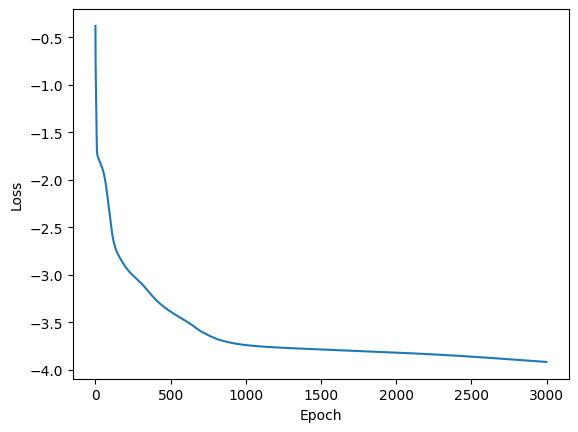

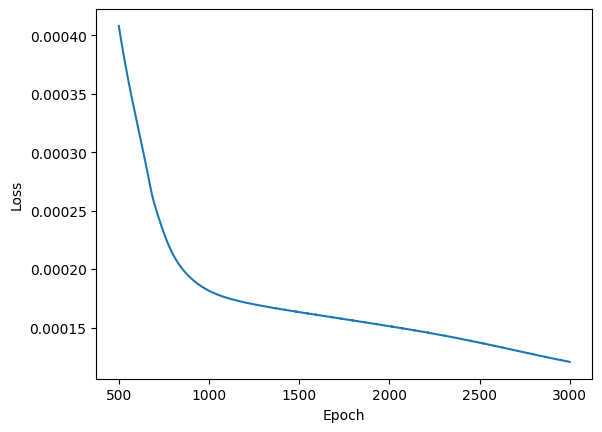

Training process has finished.


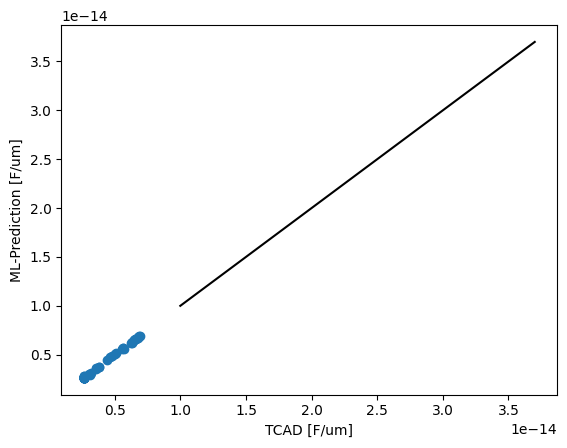

[2.65e-15, 2.65e-15, 2.65e-15, 6.61e-15, 2.68e-15, 3.77e-15, 2.65e-15, 3.79e-15, 5.01e-15, 3.61e-15, 2.65e-15, 2.65e-15, 3.11e-15, 6.53e-15, 2.65e-15, 2.65e-15, 6.29e-15, 2.65e-15, 2.65e-15, 2.65e-15, 2.65e-15, 5.07e-15, 2.68e-15, 2.65e-15, 2.65e-15, 6.47e-15, 2.65e-15, 4.8e-15, 5.58e-15, 2.65e-15, 2.65e-15, 3.56e-15, 6.5e-15, 6.88e-15, 2.65e-15, 5.62e-15, 2.65e-15, 2.65e-15, 2.65e-15, 2.65e-15, 5.66e-15, 2.65e-15, 2.65e-15, 2.65e-15, 4.67e-15, 6.34e-15, 2.65e-15, 2.69e-15, 2.65e-15, 3.03e-15, 4.44e-15, 6.8e-15, 6.27e-15, 2.65e-15, 6.74e-15, 2.65e-15, 3.19e-15, 6.9e-15, 5.7e-15, 2.66e-15]
[2.6649011773335896e-15, 2.635560803073648e-15, 2.711549399321252e-15, 6.646191504588138e-15, 2.7507702011526783e-15, 3.761250649315668e-15, 2.6369173263386756e-15, 3.743058922707487e-15, 5.097973672168413e-15, 3.5260808453564576e-15, 2.669387275580485e-15, 2.6608657006146333e-15, 2.9603096351609208e-15, 6.579761251633825e-15, 2.6628009591408725e-15, 2.6592368562570632e-15, 6.206683895949774e-15, 2.66

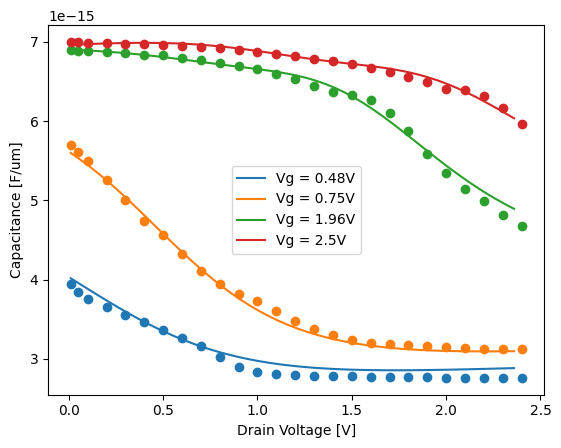

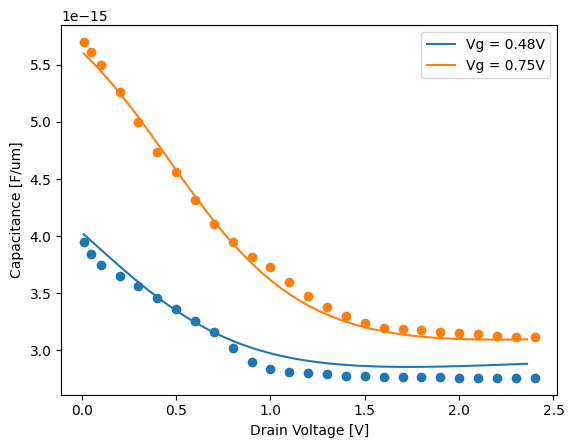

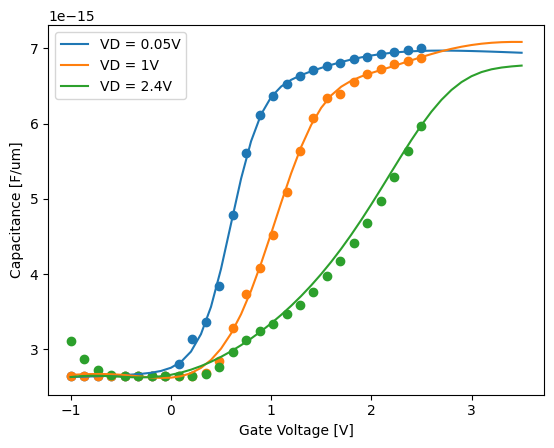

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7
  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1
  3.2  3.3  3.4  3.5]
[2.6335802e-15, 2.6361707e-15, 2.639714e-15, 2.6442679e-15, 2.6497933e-15, 2.6562777e-15, 2.6639906e-15, 2.6739233e-15, 2.6884862e-15, 2.7125963e-15, 2.7553886e-15, 2.8327096e-15, 2.9699044e-15, 3.2020696e-15, 3.5649004e-15, 4.0691158e-15, 4.6694377e-15, 5.2675014e-15, 5.7663403e-15, 6.1236366e-15, 6.353297e-15, 6.494094e-15, 6.5831994e-15, 6.6460636e-15, 6.6967263e-15, 6.741498e-15, 6.782462e-15, 6.8198222e-15, 6.8531903e-15, 6.8821766e-15, 6.906605e-15, 6.926535e-15, 6.9422177e-15, 6.954037e-15, 6.9624414e-15, 6.9679056e-15, 6.970894e-15, 6.971841e-15, 6.971138e-15, 6.969128e-15, 6.966105e-15, 6.9623152e-15, 6.9579657e-15, 6.953219e-15, 6.948206e-15, 6.9430325e-15]
[2.6601807e-15, 2.6672746e-15, 2.6718564e-15, 2.6729664e-15, 2.6698915e-15, 2.6624831e-15

In [1]:
from re import L
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch import optim
from torch.utils import data
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


import statistics
import datetime
import os
import csv
import math
import time
import numpy as np
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.getcwd()

start = time.time()

idvg_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/030424_7nm_Cgd_Vg.csv', encoding='utf8')
cv_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/022224_7nm_tech_3T_Cgg_wo25.csv', encoding='utf8')
#cv_temp=pd.read_csv(r'./cv_iwo_0206.csv', encoding='utf8')
# idvg=idvg_temp.values

lch0 = [0.007]
vd_temp=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0] #, 2.1, 2.2, 2.3, 2.4]
vd = np.array(vd_temp)
vg_temp=cv_temp.iloc[:, 0]
vg = np.array(vg_temp.values)
lch1 = np.array(lch0)

def Logset(target):
    temp = np.array(target)
    # temp[temp<0]=abs(temp)
    # temp = temp.tolist() not use
    temp = np.log10(temp)
    return temp

Ct = []
for l in list(range(len(lch1))):
    for i in list(range(len(vd))):
        temp = cv_temp.iloc[:, 2*i+1+2*len(vd)*l]
        temp = np.array(temp.values)
        Ct.extend(temp)

def normaliz(target): #Minmax normalization
    Min = min(target)
    Val = target-Min
    Max = max(Val)
    if Max == 0:
        Norm = 1
    else:
        Norm = 1/Max
    Fin = Norm*Val
    return (Norm, Val, Min, Fin)
"""
def ensure_numeric(arr):
    # Convert the array to a pandas Series to utilize 'to_numeric' and 'fillna'
    series = pd.Series(arr)
    # Attempt to convert each element to numeric, coercing errors to NaN, then replace NaNs with 0
    numeric_series = pd.to_numeric(series, errors='coerce').fillna(0)
    # Convert back to a numpy array
    numeric_arr = numeric_series.to_numpy()
    return numeric_arr

# Convert Ct to numeric and filter out any non-numeric values before normalization
Ct_numeric = ensure_numeric(Ct)
(normCt, Ct_1, MinCt, C0) = normaliz(Ct_numeric)
"""
(normCt, Ct_1, MinCt, C0)=normaliz(Ct)

(normVg, Vg_1, MinVg, Vg)=normaliz(vg)
(normVd, Vd_1, MinVd, Vd)=normaliz(vd)

(normLch, Lch_1, MinLch, Lch) = normaliz(lch1)


datasets = []
for l in list(range(len(Lch))):
    for i in list(range(len(vd))):
        for j in list(range(len(vg))):
            temp=[Vg[j],Vd[i],Lch[l], C0[j+len(vg)*(i+len(vd)*l)]]
            datasets.append(temp)

print(np.array(datasets).shape)

V = []
for i in list(range(len(datasets))):
    temp = [datasets[i][0], datasets[i][1], datasets[i][2]]
    V.append(temp)

Cte = []
for i in list(range(len(datasets))):
    temp = [datasets[i][3]]
    Cte.append(temp)

V = torch.tensor(V)
C = torch.tensor(Cte)
print(C.shape)

# dataset = list(zip(V, I))
x_train, x_test, y_train, y_test = train_test_split(V, C, test_size=0.1, random_state=41)
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32)
testdataloader = DataLoader(TensorDataset(x_test, y_test))

# Define the neural network class
class CVMLP(torch.nn.Module):
    def __init__(self):
        super(CVMLP, self).__init__()
        self.fc1 = torch.nn.Linear(3, 17)
        self.fc2 = torch.nn.Linear(17, 17)
        self.fc3 = torch.nn.Linear(17, 1)
        # self.fc3 = torch.nn.Linear(5, 1)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        # x = self.tanh(x)
        # x = self.fc4(x)
        return x

# Create an instance of the MLP class now adjusting size 3-30-25-1 --> 3-25-25-1 --> 3-20-20-1 --> 3-15-15-1
model = CVMLP()

torch.nn.init.xavier_uniform_(model.fc1.weight)
# torch.nn.init.xavier_uniform_(model.fc1.bias)
torch.nn.init.xavier_uniform_(model.fc2.weight)
# torch.nn.init.xavier_uniform_(model.fc2.bias)
torch.nn.init.xavier_uniform_(model.fc3.weight)
# torch.nn.init.xavier_uniform_(model.fc3.bias)
# torch.nn.init.xavier_uniform(model.fc4.weight)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# losses = []
# criterion = nn.MSELoss() # <== 파이토치에서 제공하는 평균 제곱 오차 함수\

nb_epochs = 3000
MLoss = []
for epoch in range(0, nb_epochs):

    current_loss = 0.0
    losses = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(dataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        L_weight = 1
        #compute loss
        batch_loss = []
        for j in range(inputs.size(0)):
            input_j = inputs[j].reshape((1, inputs.shape[1]))
            # print(input_j)
            if input_j[0,0]>0.4 and input_j[0,1]>0.4:
                batch_loss.append(L_weight*loss_function(outputs[j], targets[j]))
            else:
                batch_loss.append(loss_function(outputs[j], targets[j]))

        loss = torch.stack(batch_loss).mean()

        losses.append(loss.item())

        #perform backward pass
        loss.backward()

        #perform optimization
        optimizer.step()
        # Print statistics

    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    if (epoch + 1) % 10 == 0:
        print('Loss (epoch: %4d): %.8f' % (epoch + 1, mean_loss))
    current_loss = 0.0

    MLoss.append(mean_loss)
# Process is complete.
print('Training process has finished.')

# torch.save(model, 'IWO_idvg.pt')
# torch.save(model.state_dict(), 'IWO_idvg_state_dict.pt')

####### loss vs. epoch #######
xloss = list(range(0, nb_epochs))
plt.plot(xloss, np.log10(MLoss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(xloss[500:], MLoss[500:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

with torch.no_grad():

    output = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(testdataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        output.append(outputs)
# Process is complete.
print('Training process has finished.')

A = [1e-14, 3.7e-14]
Y = [1e-14, 3.7e-14]
output1 = output/normCt+MinCt
y_test1 = y_test/normCt+MinCt
plt.scatter(y_test1, output1)
plt.plot(A,Y, 'k')
plt.xlabel("TCAD [F/um]")
plt.ylabel("ML-Prediction [F/um]")
plt.show()

answer_test = [i for sublist in y_test1.tolist() for i in sublist]
# new_output = [i for sublist in y_test1.tolist() for i in sublist]
print(answer_test)
output_1 = [output_temp.item() for output_temp in output1]
print(output_1)

test = [[0, 0, 0]]
test_var = torch.FloatTensor(test)
pred_test = model(test_var).data.numpy()
print(pred_test/normCt+MinCt)

######################### vg = 0.48 IDVD ##############################
x_test = list(range(1, 240, 5))
x_test = np.array(x_test)/100

X= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(0.48-MinVg)*normVg, ((x_test[i])-MinVd)*normVd, 0]
    X.append(temp)

Pred_y=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y.append(pred_y)

I_pred =[i/normCt+MinCt for i in Pred_y]

I_pred=np.array(I_pred)

I_final= []
for i in list(range(len(I_pred))):
    I_final.extend(I_pred[i])

######################### vg=0.75 IDVD ##############################

X1= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(0.75-MinVg)*normVg, ((x_test[i])-MinVd)*normVd, 0]
    X1.append(temp)

Pred_y1=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X1[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y1.append(pred_y15)

I_pred1 =[  (i)/normCt+MinCt for i in Pred_y1]

I_pred1=np.array(I_pred1)

I_final1= []
for i in list(range(len(I_pred1))):
    I_final1.extend(I_pred1[i])

######################### vg=1.9 IDVD ##############################

X15= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(1.96154-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X15.append(temp)

Pred_y15=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X15[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y15.append(pred_y15)

I_pred15 =[ i/normCt+MinCt for i in Pred_y15]

I_pred15=np.array(I_pred15)

I_final15= []
for i in list(range(len(I_pred15))):
    I_final15.extend(I_pred15[i])

############# Vg = 2.5 IDVD ######################

X25= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(2.5-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X25.append(temp)

Pred_y25=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X25[i])
    pred_y25=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y25.append(pred_y25)

I_pred25 =[ i/normCt+MinCt for i in Pred_y25]

I_pred25=np.array(I_pred25)

I_final25= []
for i in list(range(len(I_pred25))):
    I_final25.extend(I_pred25[i])

Vd_test = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]
Id05_test = list(cv_temp.iloc[11, 1::2][:-1])
Id1_test = list(cv_temp.iloc[13, 1::2][:-1])
Id15_test = list(cv_temp.iloc[22, 1::2][:-1])
Id_test =  list(cv_temp.iloc[26, 1::2][:-1])
# vg = 0.48, 0.75, 1.96, 2.5
plt.scatter(Vd_test, Id05_test) ## TCAD
plt.scatter(Vd_test, Id1_test) ## TCAD
plt.scatter(Vd_test, Id15_test) ## TCAD
plt.scatter(Vd_test, Id_test) ## TCAD
plt.plot(x_test, I_final, label = "Vg = 0.48V")
plt.plot(x_test, I_final1, label = "Vg = 0.75V")
plt.plot(x_test, I_final15, label = "Vg = 1.96V")
plt.plot(x_test, I_final25, label = "Vg = 2.5V")
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Capacitance [F/um]")
plt.legend()
plt.show()

plt.scatter(Vd_test, Id05_test) ## TCAD
plt.scatter(Vd_test, Id1_test) ## TCAD
plt.plot(x_test, I_final, label = "Vg = 0.48V")
plt.plot(x_test, I_final1, label = "Vg = 0.75V")
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Capacitance [F/um]")
plt.legend()
plt.show()

#################### VD = 0.05V IDVG005 #######################

xv_test = list(range(-10, 36, 1))
xv_test = np.array(xv_test)/10

Xv= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, (0.05-MinVd)*normVd, 0]
    Xv.append(temp)

Predv_y=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Predv_y.append(pred_y)

Iv_pred =[(i/normCt+MinCt) for i in Predv_y]

Iv_pred=np.array(Iv_pred)

Iv_final= []
for i in list(range(len(Iv_pred))):
    Iv_final.extend(Iv_pred[i])

#### VD =1V ####

Xv11=[]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, (1-MinVd)*normVd, 0]
    Xv11.append(temp)

Predv_y11=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv11[i])
    pred_y11=model(new_var).data.numpy()
    Predv_y11.append(pred_y11)

Iv_pred11 =[(i/normCt+MinCt) for i in Predv_y11]

Iv_pred11=np.array(Iv_pred11)

Iv_final11= []
for i in list(range(len(Iv_pred11))):
    Iv_final11.extend(Iv_pred11[i])

#### VD =2.4V ####

Xv34=[]
for i in list(range(len(xv_test))):
    temp=[(xv_test[i]-MinVg)*normVg, (2.4-MinVd)*normVd, 0]
    Xv34.append(temp)

Predv_y34=[]
for i in list(range(len(xv_test))):
    new_var =  torch.FloatTensor(Xv34[i])
    pred_y34=model(new_var).data.numpy()
    Predv_y34.append(pred_y34)

Iv_pred34 =[(i/normCt+MinCt) for i in Predv_y34]

Iv_pred34=np.array(Iv_pred34)

Iv_final34= []
for i in list(range(len(Iv_pred34))):
    Iv_final34.extend(Iv_pred34[i])

##### below is from TCAD #####
Vg_test = list(cv_temp.iloc[:, 0])
Id0_test = list(cv_temp.iloc[:, 3])
Id_test = list(cv_temp.iloc[:, 23])
Id34_test = list(cv_temp.iloc[:, 51])
#VD = 0.05, 1, 2.4V

plt.scatter(Vg_test, (Id0_test)) ## TCAD
plt.scatter(Vg_test, (Id_test)) ## TCAD
plt.scatter(Vg_test, Id34_test)
plt.plot(xv_test, (Iv_final), label = "VD = 0.05V")
plt.plot(xv_test, (Iv_final11), label = "VD = 1V")
plt.plot(xv_test, (Iv_final34), label = "VD = 2.4V")
plt.xlabel("Gate Voltage [V]")
plt.ylabel("Capacitance [F/um]")
plt.legend()
plt.show()

print(xv_test)
print(Iv_final)
print(Iv_final11)
print(Iv_final34)

torch.save(model, 'IWO_CV.pt')
torch.save(model.state_dict(), 'IWO_CV_state_dict.pt')

# Instantiate the PyTorch model
model.load_state_dict(torch.load('IWO_CV_state_dict.pt'))

# Extract the weights and biases from the model
weights_1 = model.fc1.weight.detach().numpy()
bias_1 = model.fc1.bias.detach().numpy()
weights_2 = model.fc2.weight.detach().numpy()
bias_2 = model.fc2.bias.detach().numpy()
weights_3 = model.fc3.weight.detach().numpy()
bias_3 = model.fc3.bias.detach().numpy()

verilog_code = ""

# Create the Verilog-A code for the 1st hidden layer
verilog_code += "real hc1_0, hc1_1, hc1_2, hc1_3, hc1_4, hc1_5, hc1_6, hc1_7, hc1_8, hc1_9;\n"
verilog_code += "real hc1_10, hc1_11, hc1_12, hc1_13, hc1_14, hc1_15, hc1_16;\n"
for i in range(17):
    inputs = ["Vgs", "Vds", "Lg"]
    inputs = ["*".join([str(weights_1[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_1[i])])
    verilog_code += "hc1_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the 2nd hidden layer
verilog_code += "real hc2_0, hc2_1, hc2_2, hc2_3, hc2_4, hc2_5, hc2_6, hc2_7, hc2_8, hc2_9;\n"
verilog_code += "real hc2_10, hc2_11, hc2_12, hc2_13, hc2_14, hc2_15, hc2_16;\n"
for i in range(17):
    inputs = ["hc1_{}".format(j) for j in range(10)]
    inputs = ["*".join([str(weights_2[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_2[i])])
    verilog_code += "hc2_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the output layer
inputs = ["hc2_{}".format(i) for i in range(5)]
inputs = ["*".join([str(weights_3[0][i]), inp]) for i, inp in enumerate(inputs)]
inputs = "+".join(inputs)
inputs = "+".join([inputs, str(bias_3[0])])
verilog_code += "yc = {};\n".format(inputs)

verilog_code = """
module neural_network (d, g, s);
inout d, g, s;
electrical d, g, s;

//****** Parameters L and W ********
parameter MinVg = {} ;
parameter normVg = {} ;
parameter MinVd = {} ;
parameter normVd = {} ;
parameter MinLg = {} ;
parameter normLg = {} ;
parameter MinO = {} ;
parameter normO ={};

analog begin
	Vg = V(g);
	Vs = V(s);
	Vd = V(d);
if (Vd>=Vs) begin
	Vgs = ((Vg-Vs) - MinVg) * normVg ;
end
else begin
	Vgs = ((Vg-Vd) - MinVg) * normVg ;
end
	Vds = (abs(Vd-Vs) - MinVd) * normVd ;
	Lg = (L -MinLg)*normLg ;

{}

Cgg = (yc/normO + MinO)*W;
Cgsd = Cgg/2;

endmodule

""".format(MinVg, normVg, MinVd, normVd, MinLch, normLch, MinCt, normCt, verilog_code)

print(verilog_code)

with open("iwo_cvtest.va", "w") as f:
    f.write(verilog_code)